In [ ]:
!pip install pyprind

In [ ]:
import pandas as pd

df = pd.read_excel(io = './IssueReport.xls', sheet_name = 'Raw')
df = df[['SR NUMBER', 'SR DESCRIPTION']]
df_row_count = len(df.index)

df.head(5)

In [ ]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

porter = PorterStemmer()
nltk.download('stopwords')
stop = stopwords.words('english')

def preprocessor_marks(text, regexp, encoded_marks):
    marks = re.findall(regexp, text)
    marks = [re.sub(regexp, encoded_marks, w) for w in marks]    
    marks = ' '.join(marks)
    return ' ' + marks + ' '

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    multipleQuestionMarks = preprocessor_marks(text, '\?\?+', '??')
    multipleExcalamationMarks = preprocessor_marks(text, '\!\!+', '!!')
    text = re.sub('[\W]+', ' ', text.lower())
    text = re.sub('[0-9]', '', text)
    text = text + ''.join(emoticons).replace('-', '')
    text = text + multipleQuestionMarks
    text = text + multipleExcalamationMarks
    text = tokenizer_porter(text)
    text = [w for w in text if w not in stop]
    text = ' '.join(text)
    return text

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [4]:
import pyprind

pbar = pyprind.ProgBar(df_row_count)

for index, row in df.iterrows():
    df.at[index, 'SR DESCRIPTION'] = preprocessor(row['SR DESCRIPTION'])
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


In [5]:
df.to_excel('./IssueReport_Clean.xls')

In [6]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer


def tfid_vectorizer(max_features):
    return TfidfVectorizer(max_df=0.5, max_features = max_features,
                             min_df=2, use_idf = True);

def execute_clustering(X, n_clusters):
    return KMeans(n_clusters = n_clusters, init='k-means++', max_iter=500, n_init=10).fit(X)

In [7]:
vectorizer = tfid_vectorizer(5)
X = vectorizer.fit_transform(df['SR DESCRIPTION']);

n_clusters = 6
kmeans = execute_clustering(X, n_clusters)

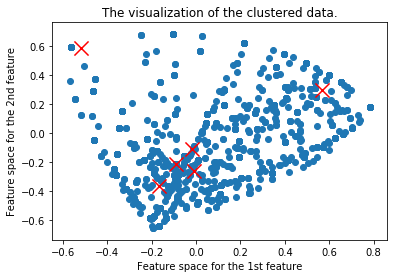

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2).fit(X.todense())

data2D = pca.transform(X.todense())
centers2D = pca.transform(kmeans.cluster_centers_)

plt.title("The visualization of the clustered data.")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")

plt.scatter(data2D[:,0], data2D[:,1])
plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.show()

([<matplotlib.axis.XTick at 0x7f84f118c690>,
 <a list of 7 Text xticklabel objects>)

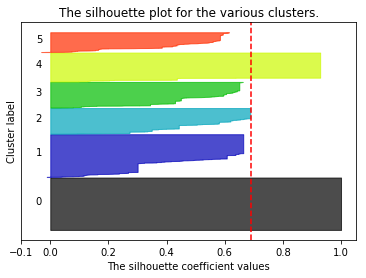

In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

silhouette_avg = silhouette_score(X, kmeans.labels_)
sample_silhouette_values = silhouette_samples(X, kmeans.labels_)

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

0% [###########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


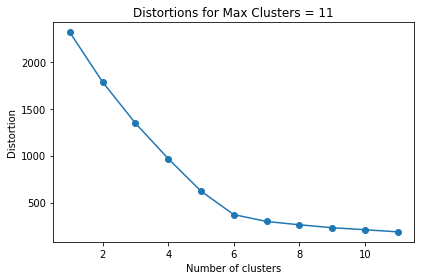

In [10]:
max_number_of_clusters = 11
pbar = pyprind.ProgBar(max_number_of_clusters)

def get_distortions_for_clustering(X, number_of_clusters):
    cluster_test = execute_clustering(X, number_of_clusters)    
    return cluster_test.inertia_

def get_distortions_for_clusterings(X, max_number_of_clusters):
    distortions = []
    for number_of_clusters in range(1, max_number_of_clusters + 1):
        distortions.append(get_distortions_for_clustering(X, number_of_clusters))
        pbar.update()
    return distortions;

def plot_distortions(distortions, max_number_of_clusters):    
    plt.title('Distortions for Max Clusters = {}'.format(max_number_of_clusters))
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')    
    plt.plot(range(1, max_number_of_clusters + 1), distortions, marker='o')
    plt.tight_layout()

def analyze_distortions_for_different_clusters(X, max_number_of_clusters):
    distortions = get_distortions_for_clusterings(X, max_number_of_clusters)
    plot_distortions(distortions, max_number_of_clusters)

analyze_distortions_for_different_clusters(X, max_number_of_clusters)

In [ ]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(n_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

In [ ]:
df['CLUSTER'] = kmeans.labels_

df.head(5)

In [13]:
df.to_excel('./IssueReport_Clusters.xls')